# Group Assignment 2.7: Extreme Value Analysis

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Extreme Value Analysis, Week 2.7, Friday, Jan 10, 2024.*

In this project, you will work on the uncertainty of precipitation in Turís, close to Valencia (Spain), where the past month of October an extreme flood occurred. Turís was the location where the highest rainfall was recorded, being also the record of that station with 771mm. You have cumulative daily observations since 1999. The dataset was retrieved from the Ministry of Agriculture [here](https://servicio.mapa.gob.es/websiar/SeleccionParametrosMap.aspx?dst=1).

**The goal of this project is:**
1. Perform Extreme Value Analysis using Yearly Maxima and GEV.
2. Perform Extreme Value Analysis using POT and GPD.
3. Compare the results from both methods in terms of return levels.

_Read the instructions for this project in `README.md` before beginning the analysis._

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats 
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 14})

## Task 1: Import and Explore Data

The first step in the analysis is importing and exploring the data set.

The dataset has two columns: the first one provides the time stamp of the measurements and the last column shows the measured precipitation (mm). We set the first column as a datetime as they are the dates of the measurements.

In [6]:
# Import
P = pd.read_csv('turis.csv', delimiter = ',', parse_dates = True)
P.columns=['Date', 'Prec'] #rename columns
P['Date'] = pd.to_datetime(P['Date'], format='mixed')
P = P.sort_values(by='Date')
P=P.reset_index(drop=True)

P.head()

,Date,Prec
0,1999-01-11,0.0
1,1999-01-12,0.0
2,1999-02-11,0.0
3,1999-02-12,0.0
4,1999-03-11,0.0


To start the data exploration, we can compute some basic statistics.

In [9]:
# values for markdown report
print(f"{P['Prec'].size:d}",
      f"{P['Prec'].min():.3f}",
      f"{P['Prec'].max():.3f}",
      f"{P['Prec'].mean():.3f}",
      f"{P['Prec'].std():.3f}",
      f"{P['Prec'].isna().sum():d}",
      f"{sum(P['Prec']==0):d}",
      sep=' | ')

8382 | 0.000 | 771.000 | 1.296 | 10.597 | 0 | 6644


We can also plot the timeseries. Notice how the event of October 2024 stands out.

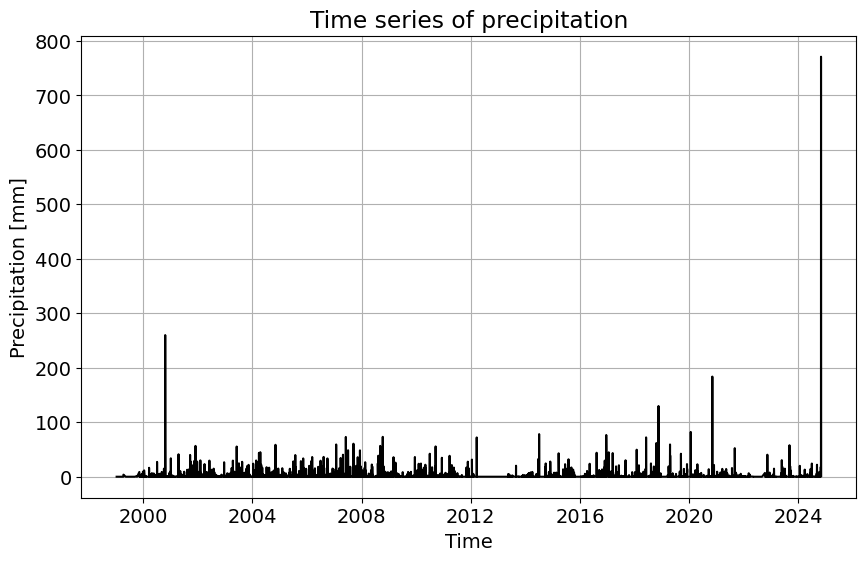

In [8]:
#Solution
plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()
plt.title('Time series of precipitation');

## Task 2: Yearly Maxima & GEV

Let's start with the first EVA analysis!

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.1:</b>   
Sample the data set by finding the yearly maxima and add the sampled extremes to your time series plot as red dots.
</p>
</div>

The shape of the sampled extremes is: (26, 2)


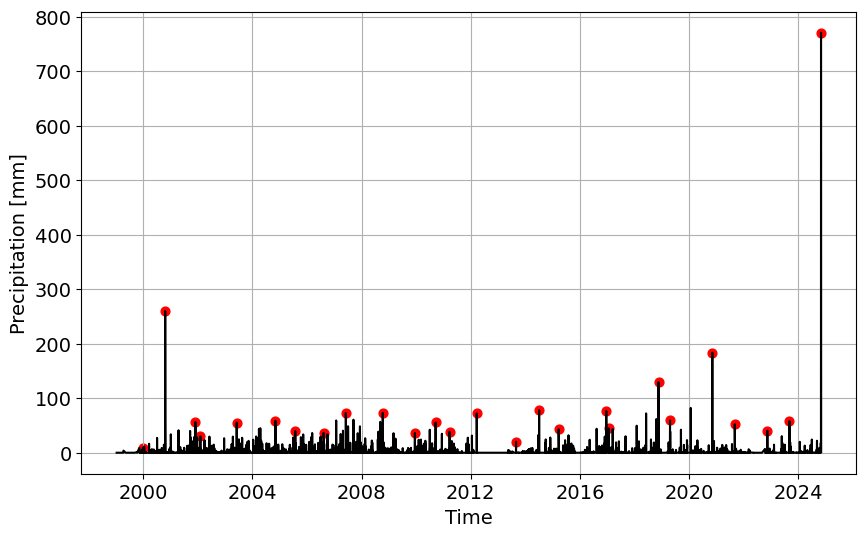

In [10]:
# Solution:
idx_max = P.groupby(pd.DatetimeIndex(P['Date']).year)['Prec'].idxmax()
YM = P.loc[idx_max]
print('The shape of the sampled extremes is:', YM.shape)

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(YM['Date'], YM['Prec'], 40, 'r')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 2.2:</b>   Compute the empirical cumulative distribution function of the sampled maxima. Fit the appropriate extreme value distribution function using <code>scipy.stats</code> and assess the fit via an exceedance plot with semi-log scale.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p><b>Tip:</b> save the parameters of an instance of <code>rv_continuous</code> as a tuple to make it easier to use the methods of the distribution later.
<br><br>For example, define parameters like this:
<br><code>params = ... .fit( ... )</code>
<br>instead of like this:
<br><code>param1, param2, param3 = ... .fit( ... )</code>
<br>(see WS 2.7 solution for examples).
</p></div>

GEV parameters are: -0.426, 45.317, 29.848


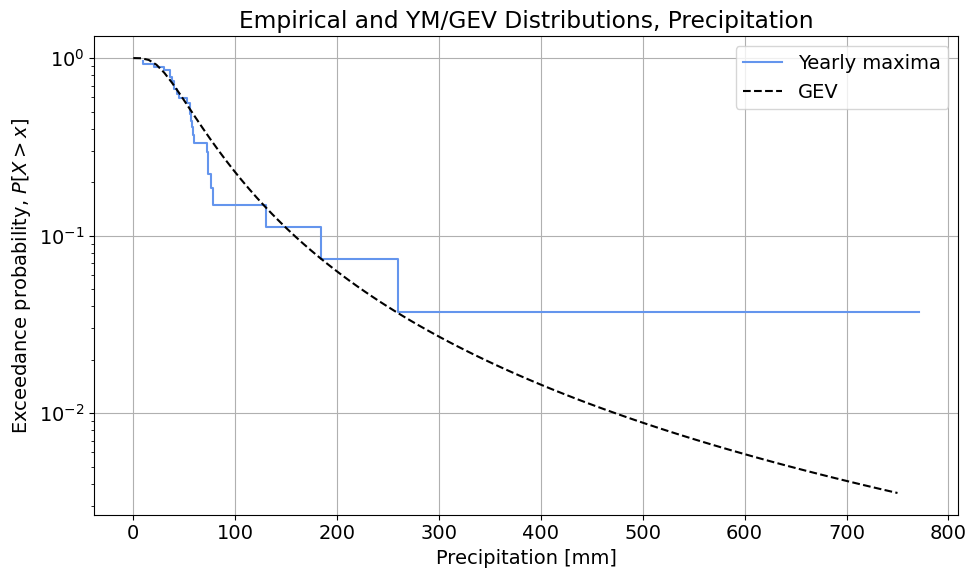

In [11]:
#Function for the ECDF
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n + 1)/(n + 1)
    return [y, x]

#Fit the parametric distribution to the extreme observations
params_YM = stats.genextreme.fit(YM['Prec'])
print('GEV parameters are: {:.3f}, {:.3f}, {:.3f}'.format(*params_YM))

#Compare both the empirical and parametric distributions in semilog scale

x_range = np.linspace(0, 750, 100)
plt.figure(figsize=(10, 6))
plt.step(ecdf(YM['Prec'])[1],
         1 - ecdf(YM['Prec'])[0],
         'cornflowerblue',
         label = 'Yearly maxima')
plt.plot(x_range,
         1 - stats.genextreme.cdf(x_range, *params_YM),
         '--k', label='GEV')
if params_YM[0]>0:
    bound = params_YM[1] - params_YM[2]/(-params_YM[0])
    plt.axvline(x = bound, color = 'red',
                linestyle = ':',
                label='Bound')
plt.xlabel('Precipitation [mm]')
plt.ylabel('Exceedance probability, $P[X > x]$')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Empirical and YM/GEV Distributions, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/gev_rain.svg');

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    Since we are applying Block Maxima to select the extreme observations, we need to fit the Generalized Extreme Value distributinon (GEV). When assessing the goodness of fit, we can see that the performance is specially poor in the tail, where the event of October 2024 totally deviates from the fit. Also, the fitted distribution underestimates the higher observations, not being on the safe side.
</div>
</div>

In [12]:
# for Markdown report
print('GEV parameters are: {0:.3f} | {3:.3f} | {1:.3f} | {2:.3f}\n'.format(*params_YM, -params_YM[0]))

if params_YM[0]>0:
    bound = params_YM[1] - params_YM[2]/(-params_YM[0])
    print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - scipy.stats shape greater than 0\n'
          '  - MUDE book shape less than 0\n'
          '  - Tail type is Reverse Weibull --> there is a bound!\n'
          '  - bound = '
          f'{params_YM[1]:.3f} - {params_YM[2]:.3f}/(-{params_YM[0]:.3f}) = {bound:.3f}')
elif params_YM[0]<0:
    print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - scipy.stats shape less than 0\n'
          '  - MUDE book shape greater than 0\n'
          '  - Tail type is Frechet --> unbounded\n')
else:
     print(f'Shape parameter from scipy.stats is {params_YM[0]:.3f}\n'
          '  - Tail type is Gumbel\n')

GEV parameters are: -0.426 | 0.426 | 45.317 | 29.848

Shape parameter from scipy.stats is -0.426
  - scipy.stats shape less than 0
  - MUDE book shape greater than 0
  - Tail type is Frechet --> unbounded



## Task 3: POT and GPD

Let's go for Peak Over Threshold (POT)---make sure you **read** this section carefully, as there are some important tips for implementing the method correctly!

As described in the book: _when performing EVA with POT, we model **excesses** over the threshold, not the actual value of the extreme event._ In principle, this can simply be described as follows:

$$
X = th + E
$$

where $X$ is the random variable of interest (rain, in this case), $th$ is the threshold and $E$ is the _excess_ (also a random variable). In other words, the distribution-fitting part of our EVA is performed on $E$. However, it is not practical to verify/validate or make inference with our distribution on the random variable $E$ for two key reasons:
1. It is more convenient to think in terms of $X$, and
2. We often need to calibrate the threshold value, which produces countless different sets of sampled extremes, distributions and random variables, $E$, which cannot be compared easily.

As such, we continue to perform our analysis in terms of $X$, while making sure to address the fact that our POT data and distributions are defined in terms of $E$. In practical terms, this means we need to <em>add and subtract the threshold value at certain points in the analysis.</em>

Note: the threshold and declustering time evaluation is outside the scope of MUDE.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 3.1:</b>   
Apply POT on the timeseries using a declustering time of 48 hours and a threshold of 40mm. Plot the sampled extremes on the timeseries as blue dots.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">Hint: you can use the function <code>find_peaks</code> from Scipy, as done in PA15.</div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    the code below to find the peaks is very similar to PA15. In this task it is not necessary to add or subtract the threshold as we are focused only on collecting the observations of the random variable (arbitrarily defined as $X$ in the explanation above).
</div>
</div>

The shape of the sampled extremes is: (38,)


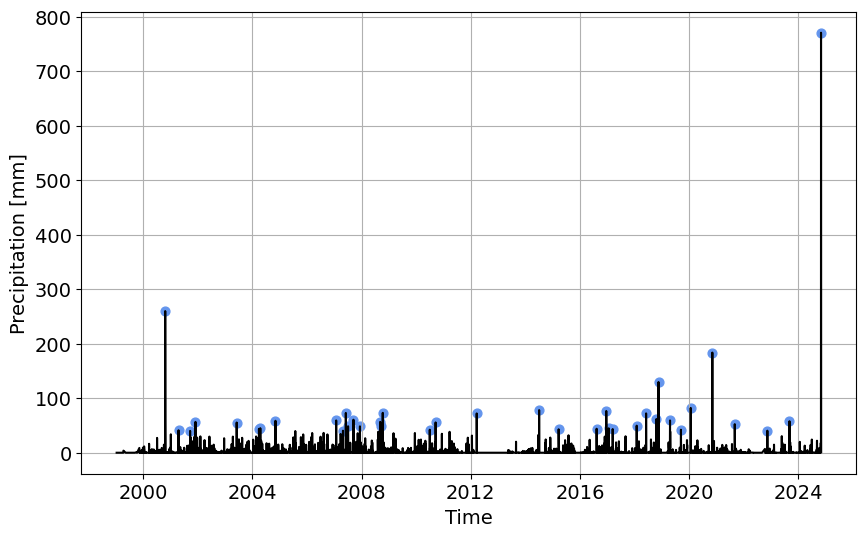

In [13]:

# Solution:
threshold = 40

distance = 2 #days
peaks, _ = find_peaks(P['Prec'], height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape)

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(P.iloc[peaks, 0], P.iloc[peaks, 1], 40, 'cornflowerblue')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 3.2:</b>   Compute the empirical cumulative distribution function of the sampled maxima. Fit the appropriate extreme value distribution function using <code>scipy.stats</code> and assess the fit via an exceedance plot with semi-log scale.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">Hint: you need to fit the appropriate distribution with a location parameter of 0 on the excesses. You can force the fitting of a distribution with a given value of the parameters using the keyword argument <code>floc</code>.</div>

GPD parameters are: 0.714, 0.000, 14.027


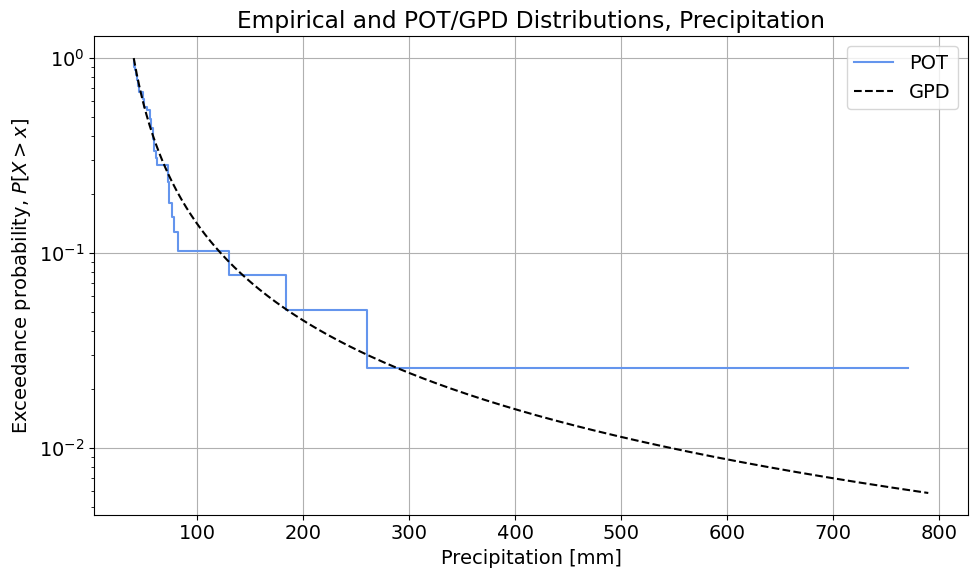

In [14]:
params_POT = stats.genpareto.fit(P.iloc[peaks, 1] - threshold, floc=0)
print('GPD parameters are: {:.3f}, {:.3f}, {:.3f}'.format(*params_POT))

excess_range = np.linspace(0, 750, 500)
plt.figure(figsize=(10, 6))
plt.step(ecdf(P.iloc[peaks, 1])[1],
         1 - ecdf(P.iloc[peaks, 1])[0],
         'cornflowerblue', label = 'POT')
plt.plot(excess_range + threshold,
         1 - stats.genpareto.cdf(excess_range, *params_POT),
         '--k', label='GPD')
if params_POT[0]<0:
    bound_POT = threshold - params_POT[2]/params_POT[0]
    print(f'Bound exists at {bound_POT:.3f}')
    plt.axvline(x = bound_POT, color = 'red',
                linestyle = ':',
                label='Bound')
plt.xlabel('Precipitation [mm]')
plt.ylabel('Exceedance probability, $P[X > x]$')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Empirical and POT/GPD Distributions, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/gpd_rain.svg');

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    in this task the threshold is subtracted from the data in the argument of the GPD fitting method (thus fitting the distribution to the excesses). In preparing the plot, note the difference between the way the empirical and theoretical CDF are used: the empirical uses the random variable values directly (the DataFrame column at index 1), whereas the GPD "adds the threshold back in" for the random variable value, and uses the excess value as the argument for the CDF.
    Regarding the fitting, the event of October 2024 is not well captured by the distribution. However, the rest of the observations seem to be better described by the distribution function. Thus, POT+GPD seem to provide a better fit that YM+GEV. This could be due to the larger sample of extremes that are obtained when using POT.
</div>
</div>

In [15]:
# for Markdown report
print('GPD parameters are: {0:.3f} | {1:.3f} | {2:.3f}\n'.format(*params_POT, params_POT[0]))

if params_POT[0]>0:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - scipy.stats and MUDE book shape greater than 0\n'
          '  - Tail type --> heavy; power function behavior\n')
elif params_POT[0]==-1:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - Tail type is Exponential\n')
elif params_POT[0]<0:
    print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - scipy.stats and MUDE book shape less than 0\n'
          '  - Tail type --> bounded\n'
          '  - bound = '
          f'{threshold:.3f} - {params_POT[2]:.3f}/({params_POT[0]:.3f}) = {bound_POT:.3f}')
else:
     print(f'Shape parameter from scipy.stats is {params_POT[0]:.3f}\n'
          '  - Tail type is Gumbel\n')

GPD parameters are: 0.714 | 0.000 | 14.027

Shape parameter from scipy.stats is 0.714
  - scipy.stats and MUDE book shape greater than 0
  - Tail type --> heavy; power function behavior



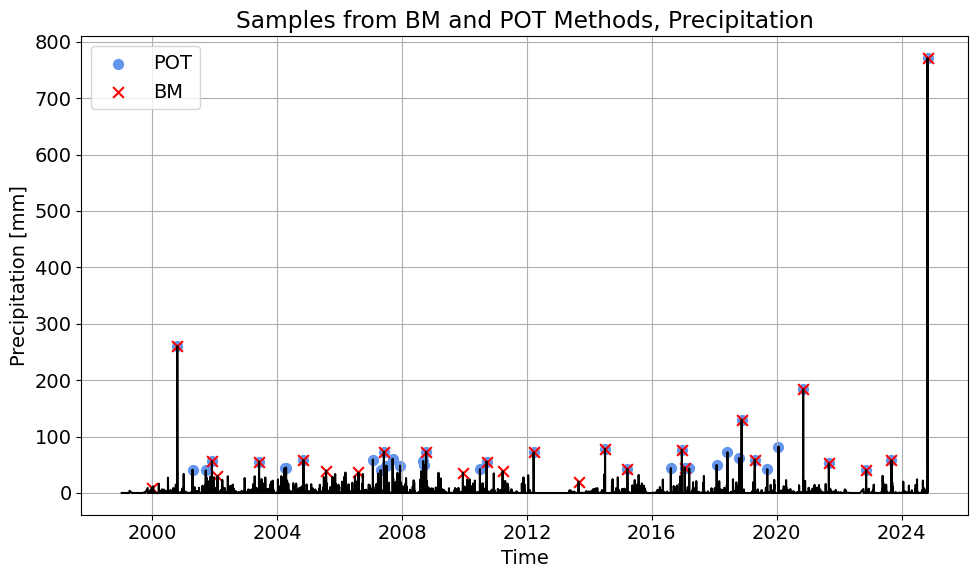

In [19]:
# Time series plot with both sets of extremes
# For Report_solution.md

plt.figure(figsize=(10, 6))
plt.plot(P['Date'], P['Prec'],'k')
plt.scatter(P.iloc[peaks, 0], P.iloc[peaks, 1],
            50, 'cornflowerblue', label='POT')
plt.scatter(YM['Date'], YM['Prec'],
            60, 'r', marker='x', label='BM')
plt.xlabel('Time')
plt.ylabel('Precipitation [mm]')
plt.grid()
plt.legend()
plt.title('Samples from BM and POT Methods, Precipitation')
plt.tight_layout()
# plt.savefig('./figures_solution/extremes_rain.png');

## Task 4: Computing Return Levels

In this section, we are going to use the distributions found in the previous two Tasks to compute the return periods that correspond to the flood of October 2024 and compare the results that both EVA methods provide.

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4.1:</b> create the return level plot for both EVA approaches (values of the random variable in the x-axis and return period on the y-axis; the y-axis in log scale). Consider return periods up to at least 800 years.
</p>
</div>

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p>Remember you can use tuple unpacking as an argument for methods of <code>scipy.stats.rv_continuous</code>, like this: <code>*params</code> (see WS 2.7 solution for examples).</p></div>

<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    here, again, note the addition of the threshold to the output of the inverse CDF method (<code>ppf</code>), thus "converting" the excess back to the original random variable.
</div>
</div>

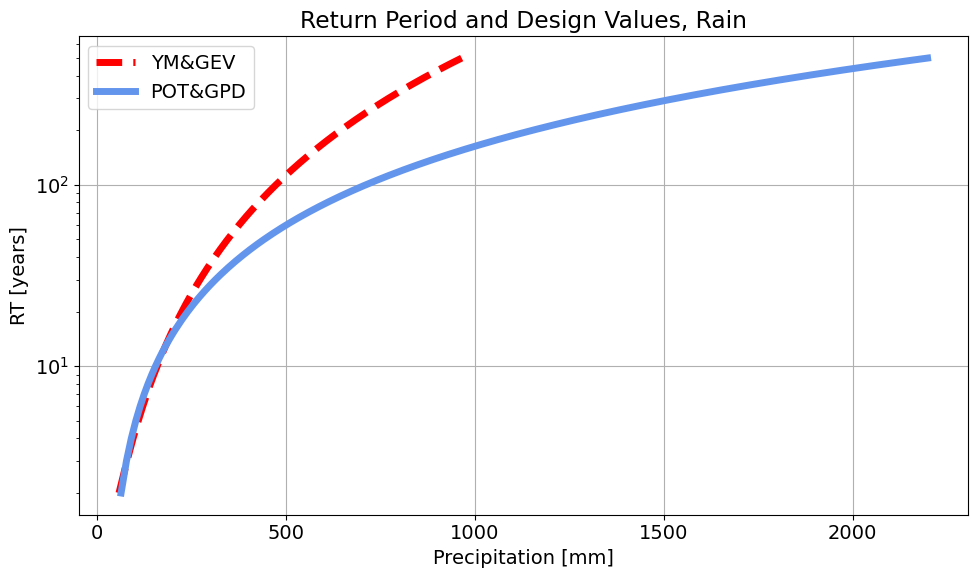

In [21]:
RT_range = np.linspace(1, 800, 500)

# YOUR_CODE_HERE (more than one line!)

# plt.figure(figsize=(10, 6))
# plt.plot(YM_range, RT_range, 'r', label = 'YM&GEV')
# plt.plot(POT_range, RT_range, 'cornflowerblue', label = 'POT&GPD')
# YOUR_FIGURE_FORMATTING_CODE_HERE (more than one line!)

# Solution:
#range of RT
RT_range = np.linspace(2, 500, 500)

#YM&GEV
YM_range = stats.genextreme.ppf(1 - 1/RT_range, *params_YM)

#POT&GPD
average_n_excesses = len(peaks)/YM.shape[0]
non_exc_prob_range = 1 - 1/(RT_range*average_n_excesses)
POT_range = stats.genpareto.ppf(non_exc_prob_range, *params_POT) + threshold

plt.figure(figsize=(10, 6))
plt.plot(YM_range, RT_range, '--r', label = 'YM&GEV', linewidth=5)
plt.plot(POT_range, RT_range, 'cornflowerblue', label = 'POT&GPD', linewidth=5)
if params_YM[0]>0:
    bound_YM = params_YM[1] - params_YM[2]/(-params_YM[0])
    plt.axvline(x = bound_YM, color = 'black',
                linestyle = ':',
                label='Bound, YM',
                linewidth=3)
if params_POT[0]<0:
    bound_POT = threshold - params_POT[2]/params_POT[0]
    print(f'Bound exists at {bound_POT:.3f}')
    plt.axvline(x = bound_POT, color = 'black',
                linestyle = ':',
                label='Bound, POT',
                linewidth=3)
plt.xlabel('Precipitation [mm]')
plt.ylabel('RT [years]')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Return Period and Design Values, Rain')
plt.tight_layout()
# plt.savefig('./figures_solution/design_rain.svg');

<div style="background-color:#AABAB2; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
<p>
<b>Task 4.2:</b> What would be the return period associated with the event of October 2024? Compare the answer provided provided by both approaches and reflect on these differences. You may reflect on:
<li>The source of the differences between both methods.
<li>Which method would be the most reliable in this situation.
<li>If possible, how to improve the reliability of the obtained results.
<li>The meaningfulness of the obtained return periods.
<li>Which return period you would assign to the event if you must assign one.
</li>
</p>
</div>

In [27]:
POT_prob

0.9939170346188034

In [29]:

#YM&GEV
YM_RT = 1/(1-stats.genextreme.cdf(771, *params_YM))

#POT&GPD
average_n_excesses = len(peaks)/YM.shape[0]
POT_prob = stats.genpareto.cdf(771 - threshold, *params_POT)
RT_POT = 1/(1-POT_prob*average_n_excesses)

#Print
print(f'The return period obtained with YM+GEV is {YM_RT:.3f}\n'
          f'The return period obtained with POT+GPD is {RT_POT:.3f}\n')

The return period obtained with YM+GEV is 300.174
The return period obtained with POT+GPD is 164.394



<div style="background-color:#FAE99E; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%">
    <b>Solution:</b>
    <li>The differences are mainly caused by the difference in the extremes selected by both methods: POT select much more observations and some observations selected by YM are not selected by POT as they are too low, although they are the biggest one in the time block.  
    <li>Based on the amount of information in which the method is applied, POT+GPD should be more realiable in this case, although we have not performed any analysis on the threshold and declustering time. Therefore, we would need to ensure that the selected extremes are independent.
    <li>Some possibilities to improve the reliability of the method is gathering more data and performing a formal anaysis to assess the threshould and declustering time of POT. Also, different time blocks could be considered in the Block Maxima method accounting for instance with the hydrologic cycle.
    <li>It is difficult to say which ret.
    <li>If I would need to choose, I'd go for the return period of the distribution that has been informed with more data and provides a better fitting, thus the one obtained using POT+GPD, RT =.
</li>
</div>
</div>

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.